# 0.0 Imports

In [1]:
import warnings

import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from IPython.display  import Image
from sklearn.manifold import TSNE
from pandas_profiling import ProfileReport

from plotly        import express  as px
from sklearn       import cluster  as cl
from sklearn       import metrics  as mt
from sklearn       import mixture  as mx
from sklearn       import ensemble as en
from sklearn       import decomposition as dd
from sklearn       import preprocessing as pp
from matplotlib    import cm            as cm
from matplotlib    import pyplot        as plt
from scipy.cluster import hierarchy     as hc

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

# 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('C:/Users/PICHAU/repos/cluster_project/data/raw/data.csv', encoding = 'unicode_escape') 

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head(5)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

## 1.1 Data Dimensions and Types

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 1.2 Check NaN's

In [7]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### 1.2.1 Replace NaN's

#### 1.2.1.1 Fill Nan's assuming that each one is unique 

In [8]:
# df_missing = df1.loc[df1['CustomerID'].isna(), :]
# df_not_missing = df1.loc[~df1['CustomerID'].isna(), :]

In [9]:
# # create reference
# df_backup = pd.DataFrame( df_missing['InvoiceNo'].drop_duplicates())
# df_backup['CustomerID'] = np.arange(19000, 19000+len( df_backup ), 1)

# # merging
# df1 = pd.merge(df1, df_backup, on='InvoiceNo', how='left')

# # coalesce 
# df1['CustomerID'] = df1['CustomerID_x'].combine_first(df1['CustomerID_y'])

# # drop extra columns
# df1 = df1.drop(columns=['CustomerID_x', 'CustomerID_y'], axis=1)

#### 1.2.1.2 Excluding NaN's

In [10]:
df1 = df1.dropna(subset=['Description', 'CustomerID'])

In [11]:
df1.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
print('Removed data: {:.0%}'.format( 1-(df1.shape[0] / df_raw.shape[0])))
print(f'New number of rows: {df1.shape[0]}')

Removed data: 25%
New number of rows: 406829


## 1.3 Change Types

In [13]:
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])
df1['CustomerID'] = df1['CustomerID'].astype('int64')

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.9+ MB


## 1.3.1 Numerical Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes      min      max     range          mean    median  \
0    Quantity -80995.0  80995.0  161990.0     12.061303      5.00   
1   UnitPrice      0.0  38970.0   38970.0      3.460471      1.95   
2  CustomerID  12346.0  18287.0    5941.0  15287.690570  15152.00   

           std        skew       kurtosis  
0   248.693064    0.182663   94317.563673  
1    69.315077  452.219019  246924.542988  
2  1713.598197    0.029835      -1.179982

<b>INVESTIGATING</b>:

== Quantity values of max and min;

== UnitPrice min as negative.

## 1.3 Descriptive Statistics

In [16]:
ds = df1[(df1['Quantity']<0)]
print('Number of rows that Quantity is negative: ', len(ds))

Number of rows that Quantity is negative:  8905


## 1.3.2 Categorical Statistics

In [17]:
cat_att = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [18]:
# invoice number
cs = cat_att[(cat_att['InvoiceNo'].str.contains('[^0-9]+', regex=True))]
print('Number of rows that invoice number has C: ', len(cs))

Number of rows that invoice number has C:  8905


In [19]:
# stock
cs2 = cat_att[(cat_att['StockCode'].str.contains('^[a-zA-Z\s]+$', regex=True))]
print('Stock code values out: {}'.format(cs2['StockCode'].unique()))

Stock code values out: ['POST' 'D' 'M' 'BANK CHARGES' 'PADS' 'DOT' 'CRUK']


In [20]:
# Country
cs3 = df1[['CustomerID', 'Country']].drop_duplicates().groupby('Country').count().reset_index()
cs3

Country  CustomerID
0              Australia           9
1                Austria          11
2                Bahrain           2
3                Belgium          25
4                 Brazil           1
5                 Canada           4
6        Channel Islands           9
7                 Cyprus           8
8         Czech Republic           1
9                Denmark           9
10                  EIRE           3
11    European Community           1
12               Finland          12
13                France          87
14               Germany          95
15                Greece           4
16               Iceland           1
17                Israel           4
18                 Italy          15
19                 Japan           8
20               Lebanon           1
21             Lithuania           1
22                 Malta           2
23           Netherlands           9
24                Norway          10
25                Poland           6
26              Portugal          19
27                   RSA           1
28          Saudi Arabia           1
29             Singapore           1
30                 Spain          31
31                Sweden           8
32           Switzerland          21
33                   USA           4
34  United Arab Emirates           2
35        United Kingdom        3950
36           Unspecified           4

# 2.0 Data Filtration

In [21]:
df2 = df1.copy()

In [22]:
len(df2)

406829

In [23]:
 # Numerical attribute 
df2 = df2[(df2['UnitPrice'] >= 0.05)]

# Categorical attributes
df2 = df2[~df2['StockCode'].isin(['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 
                                  'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# --- Description
df2 = df2.drop(columns='Description', axis=1)

# --- Country 
df2 = df2[~df2['Country'].isin(['European Community', 'Unspecified'])]

# 3.0 Feature Engineering

## 3.1 Feature Creation

In [24]:
df2['GrossRevenue'] = df2['Quantity'] * df2['UnitPrice']

In [25]:
df3 = df2.copy()

In [26]:
len(df3)

404641

In [27]:
# refference table - customer
df_ref = pd.DataFrame(df3['CustomerID']).drop_duplicates(keep='first', ignore_index=True)
df_ref = df_ref.dropna(subset=['CustomerID'])

In [28]:
# Gross Revenue (Monetary)
df_monetary = df3[['GrossRevenue','CustomerID']].groupby('CustomerID').sum().reset_index() 
df_ref = pd.merge(df_ref, df_monetary, on='CustomerID', how='left')

In [29]:
# Recency days (Recency)
df_recency = df3[['CustomerID', 'InvoiceDate']].groupby('CustomerID').max().reset_index()
df_recency['RecencyDays'] = (df3['InvoiceDate'].max() - df_recency['InvoiceDate']).dt.days
df_recency = df_recency[['CustomerID', 'RecencyDays']]
df_ref = pd.merge(df_ref, df_recency, on='CustomerID', how='left')

In [30]:
# Purchase number per day (Frequency)
df_aux = (df3[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()
                                                             .groupby('CustomerID')
                                                             .agg( max_ = ('InvoiceDate', 'max'), 
                                                                   min_ = ('InvoiceDate', 'min'),
                                                                   days_= ('InvoiceDate', lambda x: ((x.max() - x.min()).days ) + 1 ),
                                                                   buy_ = ('InvoiceNo', 'count'))).reset_index()
# Frequency
df_aux['Frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge(df_ref, df_aux[['CustomerID', 'Frequency']], on='CustomerID', how='left')

In [31]:
# ReturnsNo
df_in2 = df3[df3['InvoiceNo'].str.contains('[^0-9]+', regex=True)]
df_rn = df_in2[['CustomerID', 'InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns={'InvoiceNo':'ReturnsNo'})
df_ref = pd.merge(df_ref, df_rn, on='CustomerID', how='left')
# --- Replacing NaN's with 0
df_ref['ReturnsNo'] = df_ref['ReturnsNo'].fillna(value=0)

In [32]:
# Products Quantity
df_freq = (df3.loc[:, ['CustomerID', 'Quantity']].groupby('CustomerID').sum()
                                                           .reset_index()
                                                           .rename(columns={'Quantity': 'QtItems'}))
df_ref = pd.merge( df_ref, df_freq, on='CustomerID', how='left')

In [33]:
# Product Returns
df_in3 = df3[df3['InvoiceNo'].str.contains('[^0-9]+', regex=True)]
df_pr= df_in3[['CustomerID', 'Quantity']].groupby('CustomerID').sum().reset_index().rename(columns={'Quantity':'ProductReturns'})
df_ref = pd.merge(df_ref, df_pr, on='CustomerID', how='left')
# --- Converting negative values for positive 
df_ref['ProductReturns'] = df_ref['ProductReturns'] * -1
# --- Replacing NaN's with 0
df_ref['ProductReturns'] = df_ref['ProductReturns'].fillna(value=0)

In [34]:
# Purchase number
df_in4 = df3[~df3['InvoiceNo'].str.contains('[^0-9]+', regex=True)]
df_pn = df_in4[['CustomerID', 'InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns={'InvoiceNo':'PurchasesNo'})
df_ref = pd.merge(df_ref, df_pn, on='CustomerID', how='left')

In [35]:
# Purchasing Days
df_pd1 = df3[~df3['InvoiceNo'].str.contains('[^0-9]+', regex=True)]
df_pd2 = df_pd1[['InvoiceDate','CustomerID']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns={'InvoiceDate':'PurchasingDays'}) 
df_ref = pd.merge(df_ref, df_pd2, on='CustomerID', how='left')

In [36]:
# Products number
df_pn1 = df3[~df3['InvoiceNo'].str.contains('[^0-9]+', regex=True)]
df_pn2 = (df_pn1[['CustomerID', 'StockCode']].groupby('CustomerID')
                                                      .count()
                                                      .reset_index()
                                                      .rename(columns={'StockCode':'ProductsNo'}))

df_ref = pd.merge(df_ref, df_pn2, on = 'CustomerID', how = 'left')

In [37]:
# Purchasing month
df3['InvoiceMonth'] = df3['InvoiceDate'].dt.month
df_r = df3[['CustomerID', 'InvoiceMonth']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns={'InvoiceMonth':'PurchasingMonths'})

df_ref = pd.merge(df_ref, df_r[['CustomerID', 'PurchasingMonths']], on = 'CustomerID', how = 'left')

In [38]:
df_ref

CustomerID  GrossRevenue  RecencyDays  Frequency  ReturnsNo  QtItems  \
0          17850       5288.63          301   0.486111        1.0     1693   
1          13047       3089.10           45   0.048780        7.0     1355   
2          12583       6629.34            2   0.045822        2.0     4978   
3          13748        948.25           95   0.017921        0.0      439   
4          15100        635.10          329   0.136364        3.0       58   
...          ...           ...          ...        ...        ...      ...   
4352       13436        196.89            1   1.000000        0.0       76   
4353       15520        343.50            1   1.000000        0.0      314   
4354       13298        360.00            0   1.000000        0.0       96   
4355       14569        227.39            0   1.000000        0.0       79   
4356       12713        794.55            0   1.000000        0.0      505   

      ProductReturns  PurchasesNo  PurchasingDays  ProductsNo  \
0               40.0         34.0            33.0       297.0   
1               35.0          9.0             8.0       171.0   
2               50.0         15.0            15.0       232.0   
3                0.0          5.0             4.0        28.0   
4               22.0          3.0             3.0         3.0   
...              ...          ...             ...         ...   
4352             0.0          1.0             1.0        12.0   
4353             0.0          1.0             1.0        18.0   
4354             0.0          1.0             1.0         2.0   
4355             0.0          1.0             1.0        12.0   
4356             0.0          1.0             1.0        37.0   

      PurchasingMonths  
0                    2  
1                    9  
2                   11  
3                    3  
4                    2  
...                ...  
4352                 1  
4353                 1  
4354                 1  
4355                 1  
4356                 1  

[4357 rows x 11 columns]

## 3.2 Check NaN's From Features Created

In [39]:
df_ref.isna().sum()

CustomerID           0
GrossRevenue         0
RecencyDays          0
Frequency            0
ReturnsNo            0
QtItems              0
ProductReturns       0
PurchasesNo         28
PurchasingDays      28
ProductsNo          28
PurchasingMonths     0
dtype: int64

## 3.3 Fill NaN's

In [40]:
df_ref = df_ref.dropna()

In [41]:
df_ref.isna().sum()

CustomerID          0
GrossRevenue        0
RecencyDays         0
Frequency           0
ReturnsNo           0
QtItems             0
ProductReturns      0
PurchasesNo         0
PurchasingDays      0
ProductsNo          0
PurchasingMonths    0
dtype: int64

## 3.2 Data Filtration

In [42]:
# Some customers gross revenues results in 0, it happened because they presented a not normal comportament (buying and returning same quantities of products).
# They were considered bad users and filtered in this section.
df_ref = df_ref[df_ref['GrossRevenue']>=10]

In [43]:
df_ref.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4312 entries, 0 to 4356
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        4312 non-null   int64  
 1   GrossRevenue      4312 non-null   float64
 2   RecencyDays       4312 non-null   int64  
 3   Frequency         4312 non-null   float64
 4   ReturnsNo         4312 non-null   float64
 5   QtItems           4312 non-null   int64  
 6   ProductReturns    4312 non-null   float64
 7   PurchasesNo       4312 non-null   float64
 8   PurchasingDays    4312 non-null   float64
 9   ProductsNo        4312 non-null   float64
 10  PurchasingMonths  4312 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 404.2 KB


In [44]:
df_ref

CustomerID  GrossRevenue  RecencyDays  Frequency  ReturnsNo  QtItems  \
0          17850       5288.63          301   0.486111        1.0     1693   
1          13047       3089.10           45   0.048780        7.0     1355   
2          12583       6629.34            2   0.045822        2.0     4978   
3          13748        948.25           95   0.017921        0.0      439   
4          15100        635.10          329   0.136364        3.0       58   
...          ...           ...          ...        ...        ...      ...   
4352       13436        196.89            1   1.000000        0.0       76   
4353       15520        343.50            1   1.000000        0.0      314   
4354       13298        360.00            0   1.000000        0.0       96   
4355       14569        227.39            0   1.000000        0.0       79   
4356       12713        794.55            0   1.000000        0.0      505   

      ProductReturns  PurchasesNo  PurchasingDays  ProductsNo  \
0               40.0         34.0            33.0       297.0   
1               35.0          9.0             8.0       171.0   
2               50.0         15.0            15.0       232.0   
3                0.0          5.0             4.0        28.0   
4               22.0          3.0             3.0         3.0   
...              ...          ...             ...         ...   
4352             0.0          1.0             1.0        12.0   
4353             0.0          1.0             1.0        18.0   
4354             0.0          1.0             1.0         2.0   
4355             0.0          1.0             1.0        12.0   
4356             0.0          1.0             1.0        37.0   

      PurchasingMonths  
0                    2  
1                    9  
2                   11  
3                    3  
4                    2  
...                ...  
4352                 1  
4353                 1  
4354                 1  
4355                 1  
4356                 1  

[4312 rows x 11 columns]

# 4.0 EDA

In [45]:
df4 = df_ref.copy()

## 4.1 Univariate Analysis

In [46]:
pd.set_option('display.max_row', 1100)

### 4.1.8 Profile Report

In [47]:
univ = ProfileReport(df4)
univ.to_file('profile_outputtest.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 4.2 Bivariate Analysis

In [48]:
cols = ['CustomerID']
df42 = df4.drop(cols, axis=1)

<Figure size 1800x864 with 0 Axes>

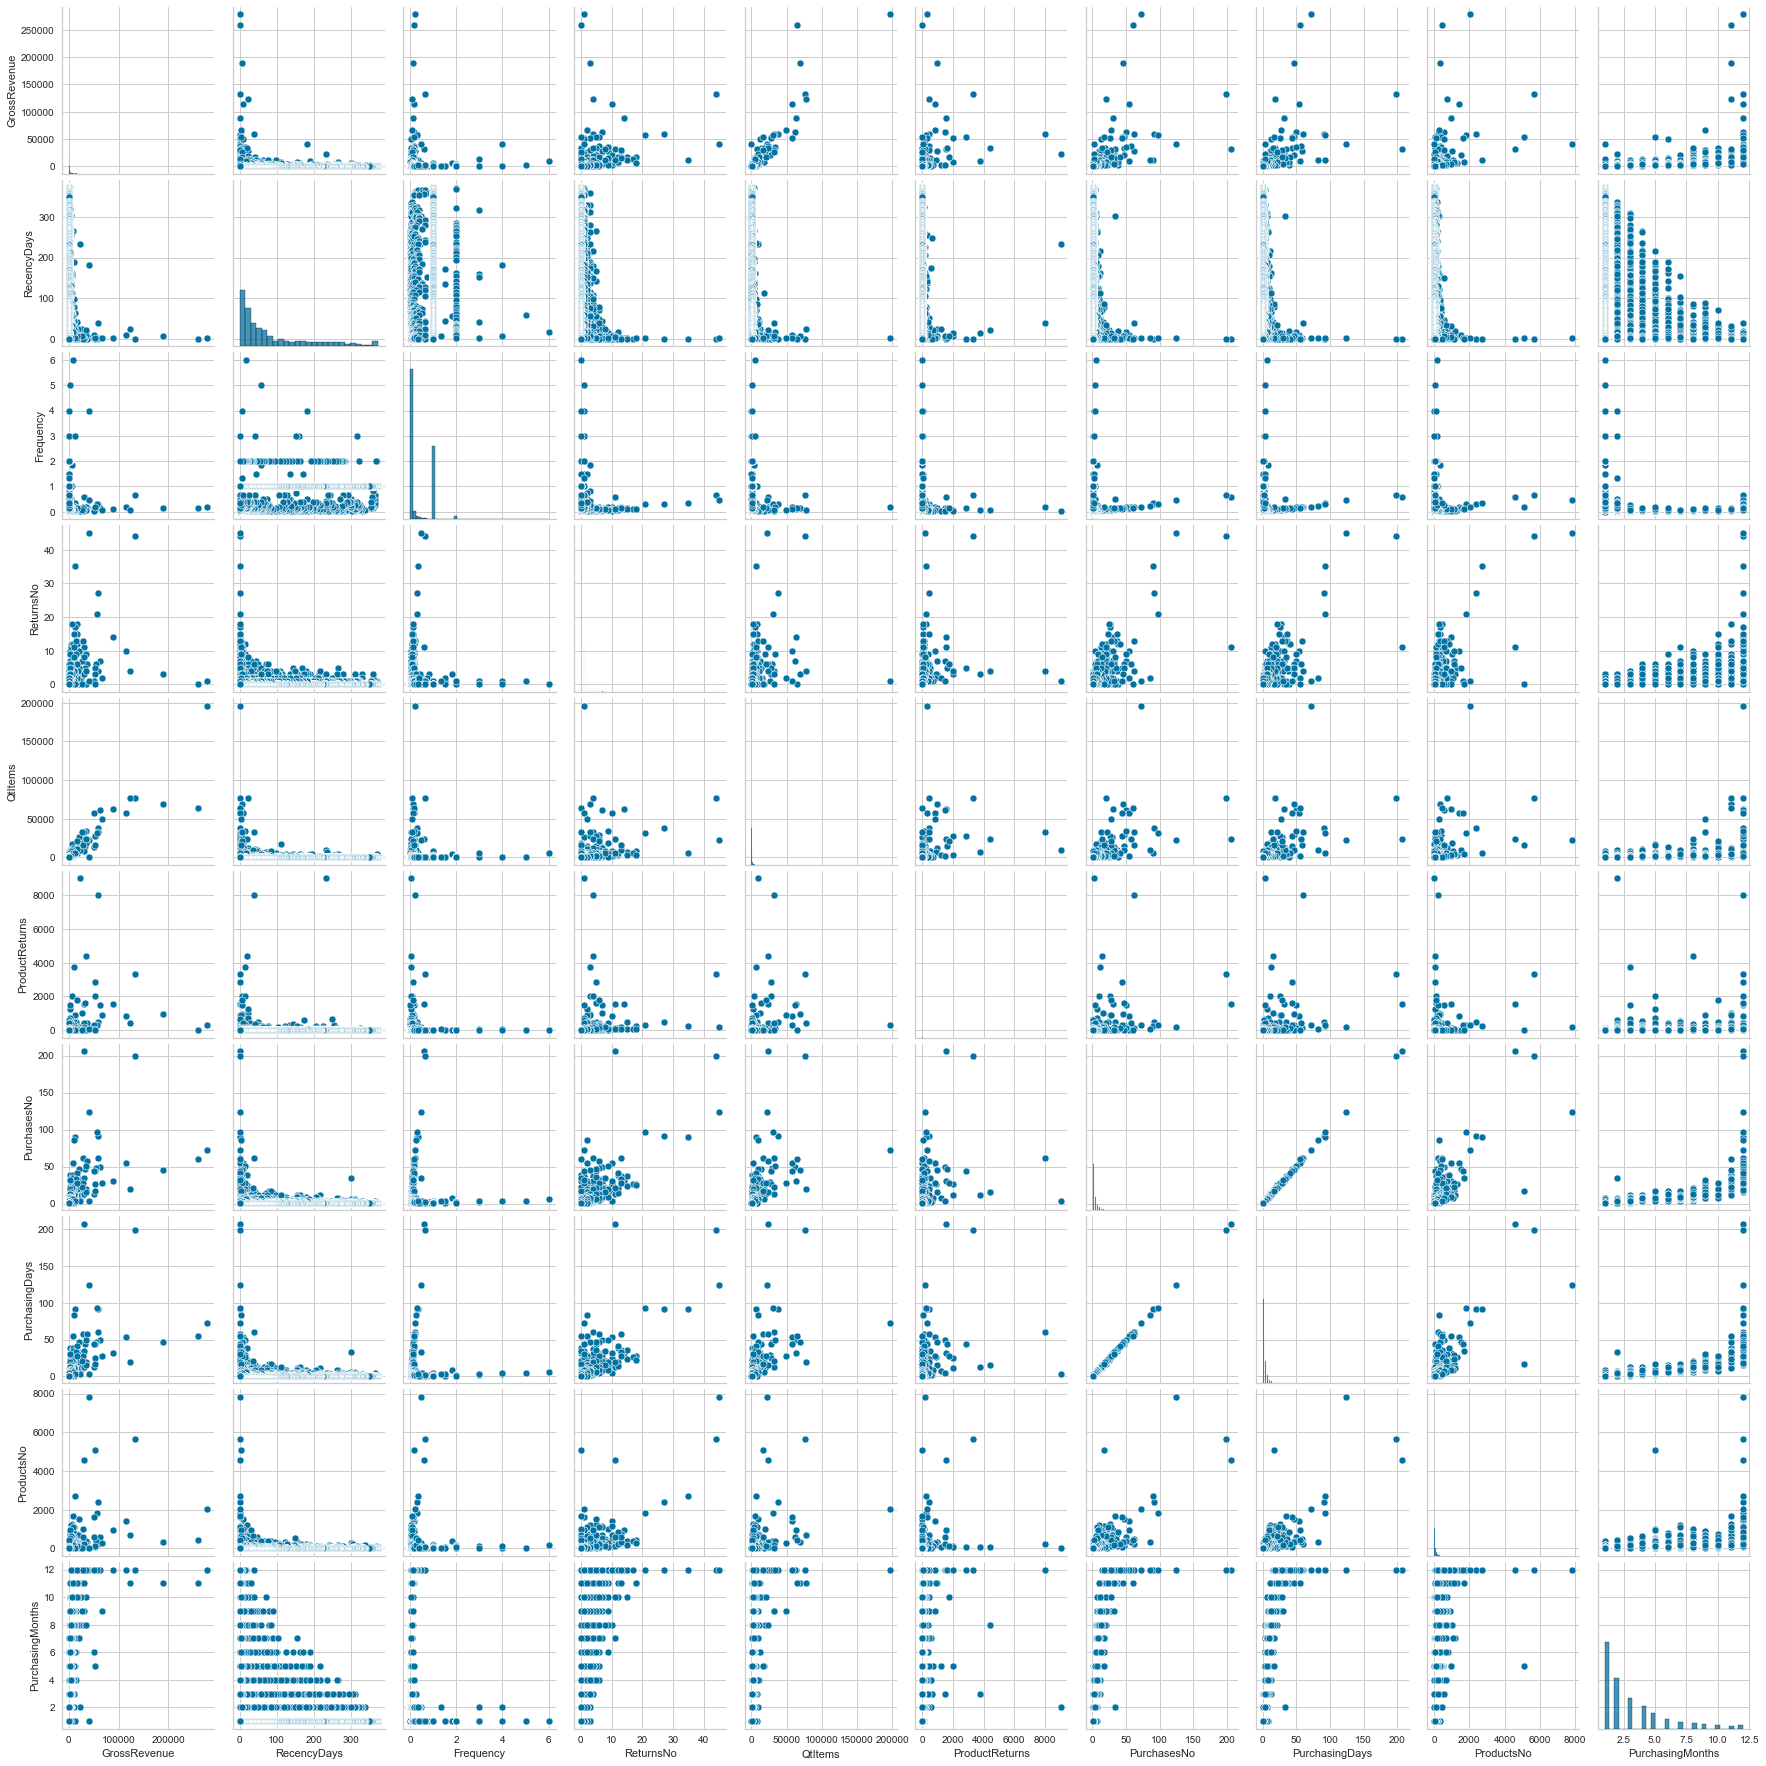

In [49]:
plt.figure(figsize=(25, 12))
sns.pairplot(df42)

## 4.3 Space Study

In [50]:
df_ref.columns

Index(['CustomerID', 'GrossRevenue', 'RecencyDays', 'Frequency', 'ReturnsNo',
       'QtItems', 'ProductReturns', 'PurchasesNo', 'PurchasingDays',
       'ProductsNo', 'PurchasingMonths'],
      dtype='object')

In [51]:
df43 = df4.drop(columns=['CustomerID'], axis=1).copy()

In [52]:
mm = pp.MinMaxScaler()

df43['GrossRevenue'] = mm.fit_transform(df43[['GrossRevenue']])
df43['RecencyDays'] = mm.fit_transform(df43[['RecencyDays']])#
df43['Frequency'] = mm.fit_transform(df43[['Frequency']])
df43['ReturnsNo'] = mm.fit_transform(df43[['ReturnsNo']])#
df43['QtItems'] = mm.fit_transform(df43[['QtItems']])
df43['PurchasesNo'] = mm.fit_transform(df43[['PurchasesNo']])
df43['PurchasingDays'] = mm.fit_transform(df43[['PurchasingDays']])#
df43['ProductsNo'] = mm.fit_transform(df43[['ProductsNo']])#
df43['PurchasingMonths'] = mm.fit_transform(df43[['PurchasingMonths']])
df43['ProductReturns'] = mm.fit_transform(df43[['ProductReturns']])#

In [53]:
df431 = df43.drop(columns=['RecencyDays', 'ReturnsNo', 'ProductsNo','PurchasingDays', 'ProductReturns'])

In [54]:
#df431 = df43.copy()

In [55]:
dfss = df431.copy()

In [56]:
dfss.head(5)

GrossRevenue  Frequency   QtItems  PurchasesNo  PurchasingMonths
0      0.018928   0.080181  0.008608     0.160976          0.090909
1      0.011037   0.007226  0.006889     0.039024          0.727273
2      0.023737   0.006732  0.025321     0.068293          0.909091
3      0.003358   0.002078  0.002228     0.019512          0.181818
4      0.002234   0.021836  0.000290     0.009756          0.090909

### 4.3.1 PCA

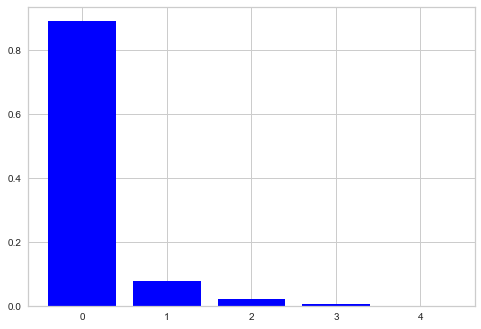

In [57]:
pca = dd.PCA(n_components=dfss.shape[1])

principal_components = pca.fit_transform(dfss)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='blue')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

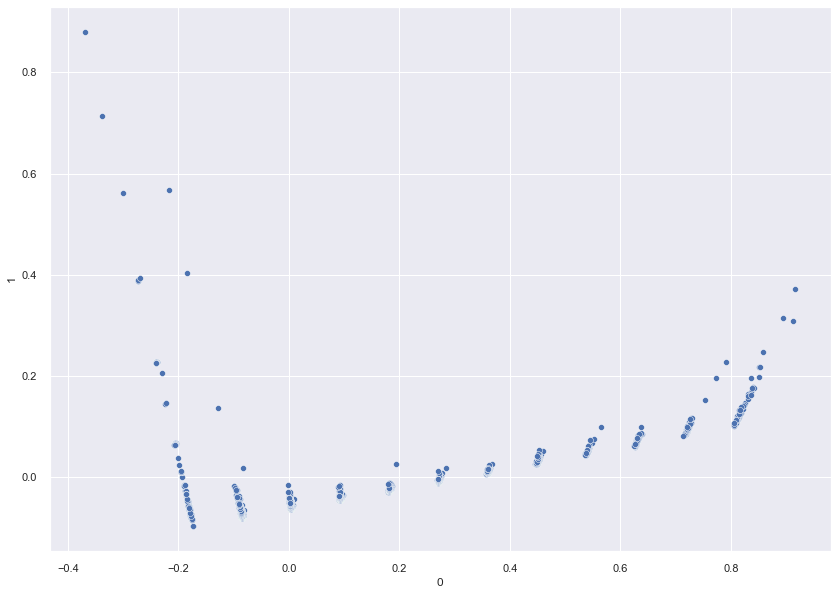

In [58]:
sns.set(rc={'figure.figsize':(14,10)}) 
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.1 UMAP

In [59]:
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(dfss)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]
df_umap['embedding_z'] = embedding[:, 2]

# plot UMAP
sns.set(rc={'figure.figsize':(14,10)})
fig = px.scatter_3d(df_umap, x='embedding_x', y='embedding_y', z='embedding_z')
fig.show()
# sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap)

### 4.3.2 t-SNE

In [60]:
reducer = TSNE(n_components=3, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(dfss)

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]
df_tsne['embedding_z'] = embedding[:, 2]

# plot UMAP
sns.set(rc={'figure.figsize':(14,10)})
fig = px.scatter_3d(df_tsne, x='embedding_x', y='embedding_y', z='embedding_z')
fig.show()
#sns.scatterplot(x='embedding_x', y='embedding_y', z='embedding_z', data=df_tsne)

### 4.3.3 Tree-Based Embedding

In [61]:
 # training dataset
X = dfss.drop(columns=['GrossRevenue'], axis=1)
y = dfss['GrossRevenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [62]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [63]:
# Reducer dimensionality
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]
df_tree['embedding_z'] = embedding[:, 2]

# plot UMAP
sns.set(rc={'figure.figsize':(10,6)})
fig = px.scatter_3d(df_tree, x='embedding_x', y='embedding_y', z='embedding_z')
fig.show()
# sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree)

# 5.0 Data Preparation

In [64]:
df5 = dfss.copy()

# 6.0 Feature Selection

In [65]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine Tunning

In [66]:
df7 = df6.copy()

In [67]:
cluster = np.arange(2,10,1)
cluster

array([2, 3, 4, 5, 6, 7, 8, 9])

## 8.0 Space Study (ML)

## 8.1 Not Dimensionality Reducer

In [68]:
Z = df6.copy()

In [69]:
#K-Means
kmeans_list = []
for k in cluster:
    # model
    kmeans = cl.KMeans(n_clusters=k)

    # trainning
    kmeans.fit(Z)

    # prediction
    klabels = kmeans.predict(Z)

    # metric
    kmeans_s = mt.silhouette_score(Z, klabels, metric='euclidean')
    kmeans_list.append(kmeans_s)

#GMM
gmm_list = []
for k in cluster:
    # model
    gmm = mx.GaussianMixture(n_components=k)

    # trainning
    gmm.fit(Z)

    # prediction
    gmmlabels = gmm.predict(Z)

    # metric
    gmm_s = mt.silhouette_score(Z, gmmlabels, metric='euclidean')
    gmm_list.append(gmm_s)
    
# HClustering
hc_list = []
for k in cluster:
    # model definition & training
    hclustering = hc.linkage(Z, 'ward')

    # model predict
    hclabels = hc.fcluster(hclustering, k, criterion='maxclust')

    # metrics
    hclustering_s = mt.silhouette_score(Z, hclabels, metric='euclidean')
    hc_list.append(hclustering_s)

Text(0.5, 1.0, 'Not Reducer - Silhouette Score')

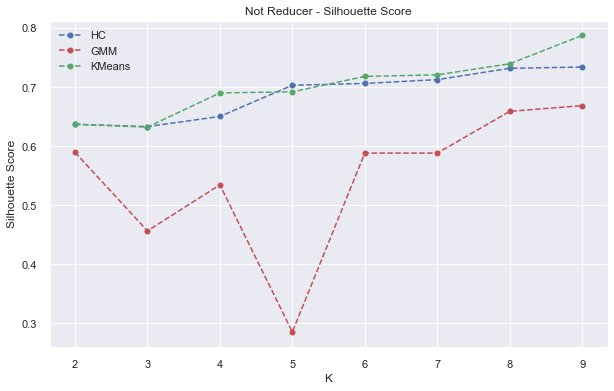

In [70]:
plt.plot(cluster,  hc_list, linestyle='--', marker='o', color='b')
plt.plot(cluster,  gmm_list, linestyle='--', marker='o', color='r')
plt.plot(cluster,  kmeans_list, linestyle='--', marker='o', color='g')
plt.legend(['HC','GMM','KMeans'])
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Not Reducer - Silhouette Score')

In [71]:
# Results
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}).T

df_results.columns = cluster

## 8.2 UMAP

In [72]:
Z = df_umap.copy()

In [73]:
#K-Means
kmeans_list = []
for k in cluster:
    # model
    kmeans = cl.KMeans(n_clusters=k)

    # trainning
    kmeans.fit(Z)

    # prediction
    klabels = kmeans.predict(Z)

    # metric
    kmeans_s = mt.silhouette_score(Z, klabels, metric='euclidean')
    kmeans_list.append(kmeans_s)

#GMM
gmm_list = []
for k in cluster:
    # model
    gmm = mx.GaussianMixture(n_components=k)

    # trainning
    gmm.fit(Z)

    # prediction
    gmmlabels = gmm.predict(Z)

    # metric
    gmm_s = mt.silhouette_score(Z, gmmlabels, metric='euclidean')
    gmm_list.append(gmm_s)
    
# HClustering
hc_list = []
for k in cluster:
    # model definition & training
    hclustering = hc.linkage(Z, 'ward')

    # model predict
    hclabels = hc.fcluster(hclustering, k, criterion='maxclust')

    # metrics
    hclustering_s = mt.silhouette_score(Z, hclabels, metric='euclidean')
    hc_list.append(hclustering_s)

Text(0.5, 1.0, 'HC - Silhouette Score')

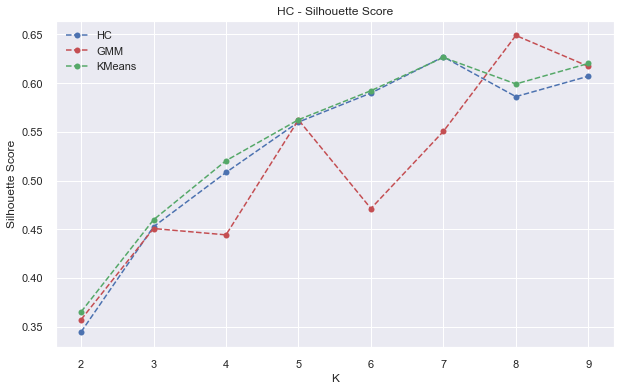

In [74]:
plt.plot(cluster,  hc_list, linestyle='--', marker='o', color='b')
plt.plot(cluster,  gmm_list, linestyle='--', marker='o', color='r')
plt.plot(cluster,  kmeans_list, linestyle='--', marker='o', color='g')
plt.legend(['HC','GMM','KMeans'])
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('HC - Silhouette Score')

In [75]:
# Results
df_results1 = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}).T

df_results1.columns = cluster

## 8.3 t-SNE

In [76]:
Z = df_tsne.copy()

In [77]:
#K-Means
kmeans_list = []
for k in cluster:
    # model
    kmeans = cl.KMeans(n_clusters=k)

    # trainning
    kmeans.fit(Z)

    # prediction
    klabels = kmeans.predict(Z)

    # metric
    kmeans_s = mt.silhouette_score(Z, klabels, metric='euclidean')
    kmeans_list.append(kmeans_s)

#GMM
gmm_list = []
for k in cluster:
    # model
    gmm = mx.GaussianMixture(n_components=k)

    # trainning
    gmm.fit(Z)

    # prediction
    gmmlabels = gmm.predict(Z)

    # metric
    gmm_s = mt.silhouette_score(Z, gmmlabels, metric='euclidean')
    gmm_list.append(gmm_s)
    
# HClustering
hc_list = []
for k in cluster:
    # model definition & training
    hclustering = hc.linkage(Z, 'ward')

    # model predict
    hclabels = hc.fcluster(hclustering, k, criterion='maxclust')

    # metrics
    hclustering_s = mt.silhouette_score(Z, hclabels, metric='euclidean')
    hc_list.append(hclustering_s)

Text(0.5, 1.0, 'T-SNE - Silhouette Score')

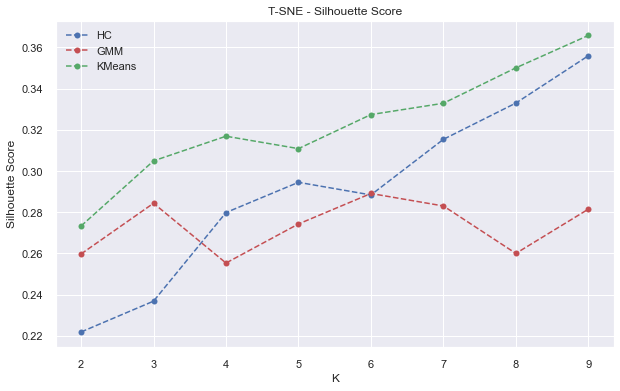

In [78]:
plt.plot(cluster,  hc_list, linestyle='--', marker='o', color='b')
plt.plot(cluster,  gmm_list, linestyle='--', marker='o', color='r')
plt.plot(cluster,  kmeans_list, linestyle='--', marker='o', color='g')
plt.legend(['HC','GMM','KMeans'])
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('T-SNE - Silhouette Score')

In [79]:
# Results
df_results2 = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}).T

df_results2.columns = cluster

## 8.4 Tree-Embedding

In [80]:
Z = df_tree.copy()

In [81]:
#K-Means
kmeans_list = []
for k in cluster:
    # model
    kmeans = cl.KMeans(n_clusters=k)

    # trainning
    kmeans.fit(Z)

    # prediction
    klabels = kmeans.predict(Z)

    # metric
    kmeans_s = mt.silhouette_score(Z, klabels, metric='euclidean')
    kmeans_list.append(kmeans_s)

#GMM
gmm_list = []
for k in cluster:
    # model
    gmm = mx.GaussianMixture(n_components=k)

    # trainning
    gmm.fit(Z)

    # prediction
    gmmlabels = gmm.predict(Z)

    # metric
    gmm_s = mt.silhouette_score(Z, gmmlabels, metric='euclidean')
    gmm_list.append(gmm_s)
    
# HClustering
hc_list = []
for k in cluster:
    # model definition & training
    hclustering = hc.linkage(Z, 'ward')

    # model predict
    hclabels = hc.fcluster(hclustering, k, criterion='maxclust')

    # metrics
    hclustering_s = mt.silhouette_score(Z, hclabels, metric='euclidean')
    hc_list.append(hclustering_s)

Text(0.5, 1.0, 'Tree Based - Silhouette Score')

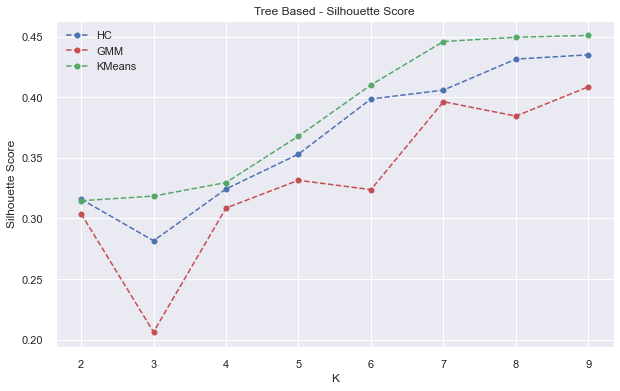

In [82]:
plt.plot(cluster,  hc_list, linestyle='--', marker='o', color='b')
plt.plot(cluster,  gmm_list, linestyle='--', marker='o', color='r')
plt.plot(cluster,  kmeans_list, linestyle='--', marker='o', color='g')
plt.legend(['HC','GMM','KMeans'])
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Tree Based - Silhouette Score')

In [83]:
# Results
df_results3 = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}).T

df_results3.columns = cluster

## 8.4 Comparing Results

In [84]:
# Not Dimensionality Reducer
df_results.style.highlight_max(color='lightgreen', axis=1)

In [85]:
# UMAP
df_results1.style.highlight_max(color='lightgreen', axis=1)

In [86]:
# t-SNE
df_results2.style.highlight_max(color='lightgreen', axis=1)

In [87]:
# Tree Based
df_results3.style.highlight_max(color='lightgreen', axis=1)

# 8.0 Model Trainning

<b>Note: Analyzing business restrictions and the results for 10 clusters, a restriction from business assumptions. </b>

In [88]:
# Selecting the best embedding space: Not Dimensionality Reducer(df6), UMAP(df_umap), t-SNE(df_tsne) and Tree-Based(df_tree).
df8 = dfss.copy()

## 8.1 K-Means

In [89]:
# Clusters
k=6

# Model
kmeansf = cl.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

kmeansf.fit(df8)

kflabels = kmeansf.labels_

### 8.1.2 Cluster Validation

In [90]:
# SS
print('Silhouette Score KMeans: ', mt.silhouette_score(df8, kflabels, metric='euclidean'))

Silhouette Score KMeans:  0.7178501698736811


# 9.0 Cluster Analysis

In [91]:
df9 = df8.copy()
df9['Clusters'] = kflabels

In [92]:
df9.head(5)

GrossRevenue  Frequency   QtItems  PurchasesNo  PurchasingMonths  Clusters
0      0.018928   0.080181  0.008608     0.160976          0.090909         3
1      0.011037   0.007226  0.006889     0.039024          0.727273         4
2      0.023737   0.006732  0.025321     0.068293          0.909091         5
3      0.003358   0.002078  0.002228     0.019512          0.181818         1
4      0.002234   0.021836  0.000290     0.009756          0.090909         3

## 9.4 Cluster Profile

In [93]:
df94 = df4.copy() 
df94['Clusters'] = kflabels
df94.sample(5)

CustomerID  GrossRevenue  RecencyDays  Frequency  ReturnsNo  QtItems  \
2568       15865        895.13           40   0.017241        0.0      368   
3639       13347        341.36           69   1.000000        0.0      205   
1726       12598       2786.68            9   0.028986        1.0     1928   
3494       17628         75.75           80   1.000000        0.0       79   
4277       17232        421.52            2   0.166667        0.0      203   

      ProductReturns  PurchasesNo  PurchasingDays  ProductsNo  \
2568             0.0          3.0             3.0        40.0   
3639             0.0          1.0             1.0         8.0   
1726            24.0          7.0             7.0       127.0   
3494             0.0          1.0             1.0         5.0   
4277             0.0          2.0             2.0        36.0   

      PurchasingMonths  Clusters  
2568                 3         1  
3639                 1         2  
1726                 6         0  
3494                 1         2  
4277                 2         3

In [94]:
# clusters composition by total database 
df_cluster = df94[['CustomerID', 'Clusters']].groupby('Clusters').count().reset_index()

In [95]:
df_cluster['Pencentage'] = 100 * (df_cluster['CustomerID'] / df_cluster['CustomerID'].sum())

# Gross revenue average
avg_rev = df94[['Clusters', 'GrossRevenue']].groupby('Clusters').mean().reset_index() 
df_cluster = pd.merge(df_cluster, avg_rev, on= 'Clusters', how='inner')

# Recency average
avg_rec = df94[['Clusters', 'RecencyDays']].groupby('Clusters').mean().reset_index() 
df_cluster = pd.merge(df_cluster, avg_rec, on= 'Clusters', how='inner')

# PurchasesNo average
avg_pn = df94[['Clusters', 'PurchasesNo']].groupby('Clusters').mean().reset_index() 
df_cluster = pd.merge(df_cluster, avg_pn, on= 'Clusters', how='inner')

# Frequency average
avg_t = df94[['Clusters', 'Frequency']].groupby('Clusters').mean().reset_index()
df_cluster = pd.merge(df_cluster, avg_t, on= 'Clusters', how='inner')

# PurchasinMonths average
avg_t = df94[['Clusters', 'PurchasingMonths']].groupby('Clusters').mean().reset_index() 
df_cluster = pd.merge(df_cluster, avg_t, on= 'Clusters', how='inner')

df_cluster.sort_values('GrossRevenue', ascending=False)

Clusters  CustomerID  Pencentage  GrossRevenue  RecencyDays  PurchasesNo  \
5         5         183    4.243970  17729.922623     7.683060    27.142077   
4         4         287    6.655844   4327.650976    18.533101    10.783972   
0         0         458   10.621521   2599.532118    33.569869     6.482533   
1         1         944   21.892393   1396.100201    54.940678     3.848517   
3         3        1031   23.910019    718.016004    94.170708     2.142580   
2         2        1409   32.676252    396.150227   152.885025     1.064585   

   Frequency  PurchasingMonths  
5   0.092202         10.972678  
4   0.042049          7.867596  
0   0.030675          5.382096  
1   0.030501          3.421610  
3   0.071038          1.867119  
2   1.056671          1.002129

<b>CLUSTER 5 (VEIGHERS): </b>

Total: 183 customers (4.2% of total customers)

Spent (avg): $ 17729.92 

Recency (avg):  8 days

Purchase (avg): 27 purchases

Purchasing Months (avg): 11 months 

-------------------------------------------------

<b>CLUSTER 4 (ASCENDING): </b>

Total: 287 customers (6.6% of total customers)

Spent (avg): $ 4327.65  

Recency (avg): 19 days

Purchase (avg): 11 purchases

Purchasing Months (avg): 8 months  

-------------------------------------------------

<b>CLUSTER 0 (IMPROVE): </b>

Total: 458 customers (10.62% of total customers)

Spent (avg): $ 2599.53 

Recency (avg): 34 days

Purchase (avg): 6 purchases

Purchasing Months (avg): 6 months 

-------------------------------------------------

<b>CLUSTER 1 (RESCUE): </b>

Total: 944 customers (21.89% of total customers)

Spent (avg): $ 1396.10

Recency (avg): 55 days

Purchase (avg): 4 purchases

Purchasing Months (avg): 4 months  

-------------------------------------------------

<b>CLUSTER 3: </b>

Total: 1031 customers (23.91% of total customers)

Spent (avg): $ 718.01

Recency (avg): 95 days

Purchase (avg): 2 purchases

Purchasing Months (avg): 2 months  

-------------------------------------------------

<b>CLUSTER 2: </b>

Total: 1409 customers (32.67% of total customers)

Spent (avg): $ 396.15

Recency (avg): 153 days

Purchase (avg): 1 purchases

Purchasing Months (avg): 1 months  

# 10.0 Hypothesis MindMap

In [96]:
df10 = df94.copy()

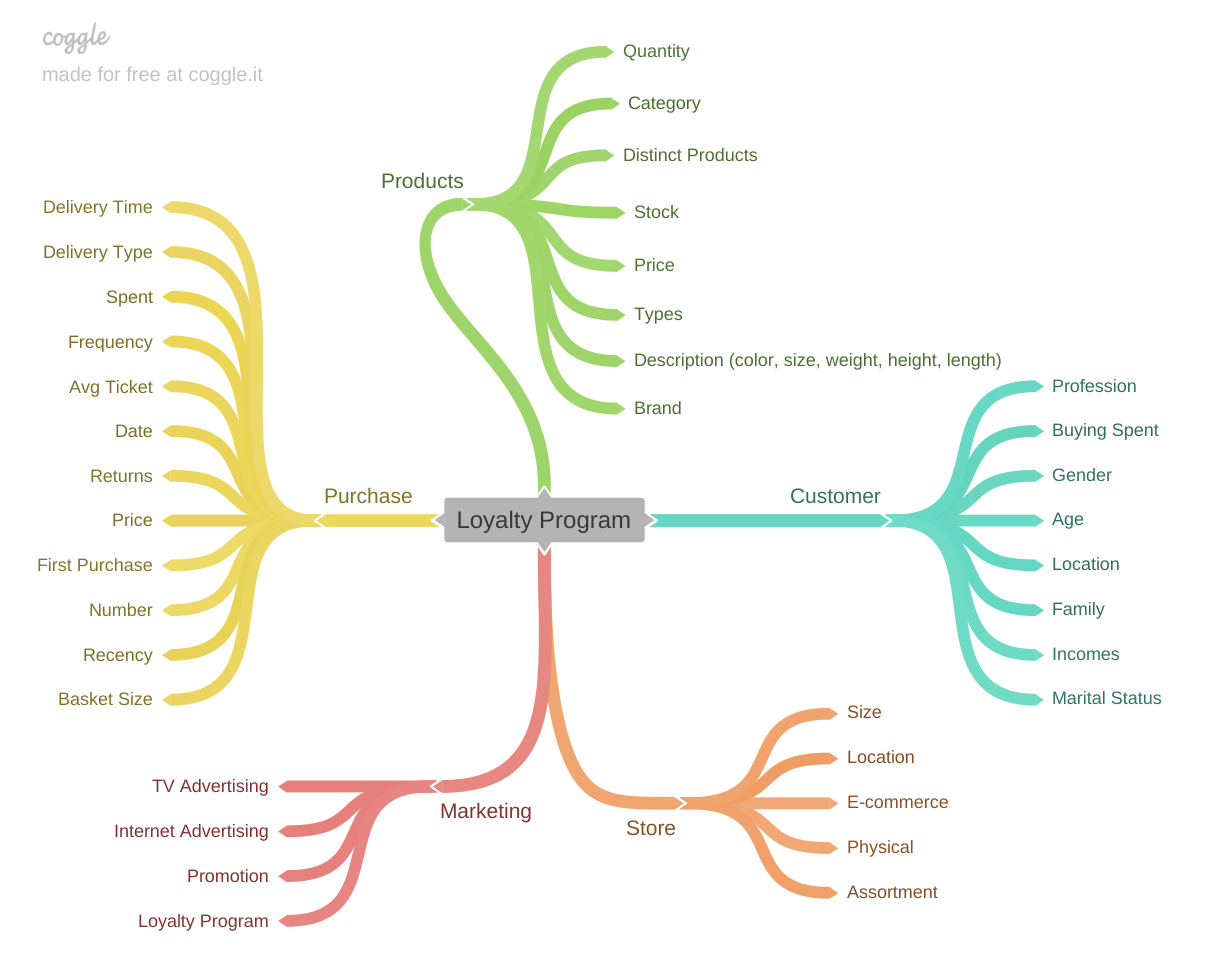

In [97]:
Image('C:/Users/PICHAU/repos/cluster_project/image/clustering_h.png')

## 10.1 Veighers Business Hypothesis

H1: Veighers represents 30% of total gross revenue.

H2: Veighers represents 25% of total purchases.

H3: Veighers returns median are 15% less than total returns median.

H4: Veighers, Ascending and Improve gross revenue, represents 80% of total gross revenue.  

H5: Veighers median recency are 80% less than total customers median recency. 

### H1: Veighers represents 30% of total gross revenue.

In [98]:
dfv = df10.loc[df10['Clusters'] == 5, 'GrossRevenue'].sum()
dft = df10.loc[:, 'GrossRevenue'].sum()
print('------------------------------------------------------')
print('Veighers percentage of total gross revenue: {:.2f}%'.format(100*dfv/dft))
print('------------------------------------------------------')

------------------------------------------------------
Veighers percentage of total gross revenue: 39.12%
------------------------------------------------------


<b>FALSE</b>: Veighers represents 39.12% of total gross revenue, even more than the hypothesis.

### H2: Veighers represents 25% of total purchases.

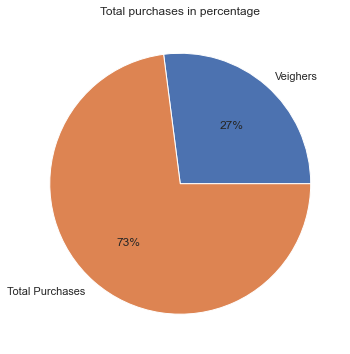

In [99]:
dfv = df10.loc[df10['Clusters'] == 5, 'PurchasesNo'].sum()
dft = df10.loc[:, 'PurchasesNo'].sum()
 
a1 = 100*dfv/dft
a2 = 100 - a1   
x1 = [a1, a2]
x2 = ['Veighers','Total Purchases']

plt.pie(x1, labels = x2, autopct='%.0f%%')
plt.title('Total purchases in percentage')
plt.show()

<b>TRUE</b>: Veighers represents 27% of total purchases, even more than the hypothesis.

### H3: Veighers returns median are 35% less than total returns median.

In [100]:
dfv = df10.loc[df10['Clusters'] == 5, 'ReturnsNo'].mean()
dft = df10['ReturnsNo'].mean()

print('-------------------------------------------------------------')
print('Veighers average returns, {} products.'.format(dfv))
print('-------------------------------------------------------------')
print('Total customers average returns, {} products.'.format(dft))
print('-------------------------------------------------------------')

-------------------------------------------------------------
Veighers average returns, 5.546448087431694 products.
-------------------------------------------------------------
Total customers average returns, 0.7727272727272727 products.
-------------------------------------------------------------


<b>TRUE</b>: Veighers returns are 34% less than total returns.

### H4: Veighers, Ascending and Improve gross revenue represents 80% of total gross revenue.

In [101]:
dft = df10['GrossRevenue'].sum()
dfv = df10[['Clusters', 'GrossRevenue']].groupby('Clusters').sum().reset_index()
dfv['Percentage'] = 100*dfv['GrossRevenue']/dft
dfv

Clusters  GrossRevenue  Percentage
0         0    1190585.71   14.355534
1         1    1317918.59   15.890855
2         2     558175.67    6.730225
3         3     740274.50    8.925889
4         4    1242035.83   14.975896
5         5    3244575.84   39.121601

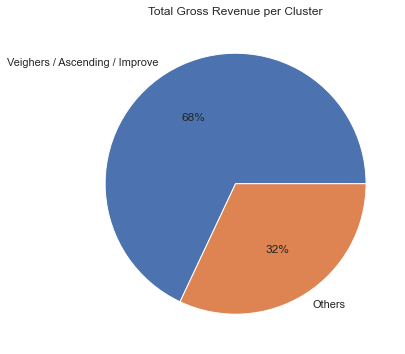

In [102]:
#plt.pie(dfv['Percentage'], labels = dfv['Clusters'], autopct='%.0f%%')
sum1 = 14 + 15 + 39
sum2 = 16 + 7 + 9
dfg = [sum1, sum2]
dfg1 = ['Veighers / Ascending / Improve', 'Others']
#sns.barplot(y = dfg, x = dfg1)
plt.pie(dfg, labels = dfg1, autopct='%.0f%%')
plt.title('Total Gross Revenue per Cluster')
plt.show()

<b>FALSE</b>:  The more representative clusters (Veighers/Ascending/Improve) represents 70% of total gross revenue.

### H5: Veighers median recency are 80% less than total customers median recency.

Text(0.5, 1.0, 'Recency Days Boxplot - Veighers')

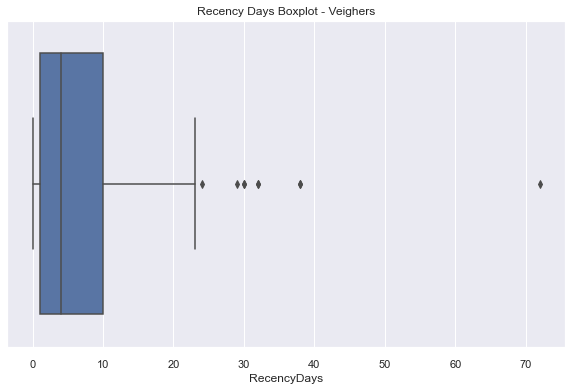

In [103]:
dfv = df10.loc[df10['Clusters'] == 5, 'RecencyDays']
dft = df10.loc[:, 'RecencyDays']

sns.boxplot(dfv, x ='RecencyDays')
plt.title('Recency Days Boxplot - Veighers')

In [104]:
dfv1 = df10.loc[df10['Clusters'] == 5]
print('Veighers Recency Days: ',dfv1['RecencyDays'].median())

Veighers Recency Days:  4.0


Text(0.5, 1.0, 'Recency Days Boxplot - Not Veighers')

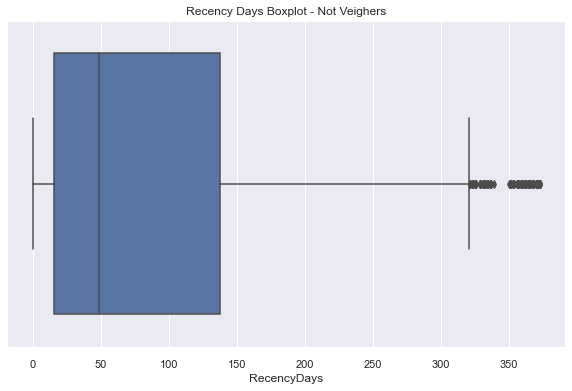

In [105]:
sns.boxplot(dft, x ='RecencyDays')
plt.title('Recency Days Boxplot - Not Veighers')

In [106]:
dfv1 = df10.loc[df10['Clusters'] != 5]
print('Veighers Recency Days: ',dfv1['RecencyDays'].median())

Veighers Recency Days:  51.0


<b>FALSE</b>: Veighers recency days are approximately 10 times less than total returns.